# Project 1: Milestone 2 - White Paper
### DSC680-T301 Applied Data Science
### Joshua Greenert
### 3/18/2023

## Business Problem

Businesses and individuals alike invest in housing to provide for their family, or to rent out their property to gain residual income.  According to the Internal Revenue Service, in 2018 approximately 10.3 million individual filers reported they were owners of rental properties while owning 1.72 properties on average (Pew Research Center, 2021).  Throughout this project, we will attempt to discover whether these owners should be considering selling their investments, whether their homes will be massively underwater, and whether the housing market will remain stable for existing and new investors.  We will also be attempting to gain insight for millions of homeowners of whom may be worried during these tumultuous times.

## Background and History

The housing market has always been a crucial aspect of the economy, and the volatility and unpredictability make it a significant challenge for any investor to make informed decisions on buying, selling, or renting properties.  Historically speaking, the housing market has experienced significant fluctuations, with the most notable being the housing bubble and subsequent crash in 2008.  This crash led to a severe recession, with many homeowners losing their homes, and a market that took several years to recover.

Afterwards, the housing market made a gradual recovery, with prices increasing year after year.  However, the Covid-19 pandemic has had a significant impact on the market, creating uncertainty and instability for homeowners, buyers, and sellers alike.  In this context, accurate predictions of future housing prices are essential for making informed decisions.  Machine learning models can assist in forecasting future housing prices by analyzing trends and patterns in historical data, providing insights for investors and homeowners.

In this white paper, we will explore the potential of machine learning models to predict future housing prices while examining their accuracy, reliability, and limitations.  Additionally, we will also explore the implications of the findings for homeowners, investors, and the housing market for future viability.

## Data Preparation

In [1]:
# Set some required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pull in the data.
df_housing = pd.read_csv('Housing.csv')
df_hpi = pd.read_csv('HPI_master.csv')
df_state_stats = pd.read_excel('state_statistics_for_download.xls')

### State Stats Dataset

In [2]:
# Fix the state stats dataframe.
# Correct the row headers for the state stats.
df_state_stats.columns = df_state_stats.iloc[3]

#remove first row from DataFrame
df_state_stats = df_state_stats[4:]

# Remove all values of US from the State column
df_state_stats = df_state_stats[df_state_stats['State'] != 'US']

# Remove the rows with Q2, Q3, and Q4 data.
df_state_stats = df_state_stats[~df_state_stats['Year-Quarter'].str.contains('Q[234]')]

In [3]:
# Loop through the dataframe and replace each year-quarter with an actual date object.
import datetime

for index, row in df_state_stats.iterrows():
    year = int(row['Year-Quarter'][0:4])
    date = datetime.date(year, 1, 1)
    df_state_stats.at[index,'Year-Quarter'] = date

# Show the head to confirm working
df_state_stats.head(3)

3,State,Year-Quarter,Average Price,Median Price
46,AK,2000-01-01,159887,148406
50,AK,2001-01-01,168500,155637
54,AK,2002-01-01,175754,161283


### Housing Dataset

In [4]:
# Fix the area codes so that they are strings and have 0's at the beginning if the number is less than 5 digits.
for index, row in df_housing.iterrows():
    if(len(str(row['area'])) < 5):
        zipCode = "0" + str(row['area'])
        df_housing.at[index,'area'] = zipCode
    else:
        df_housing.at[index,'area'] = str(row['area'])
        
df_housing.head(3)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,07420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,08960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,09960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished


### HPI Dataset

In [5]:
# Remove all rows with level that is not equal to state.
df_hpi = df_hpi[df_hpi['level'] == 'State']

# Remove all the periods not equal to 1
df_hpi = df_hpi[df_hpi['period'] == 1]

# Update the year to be a date; otherwise visuals won't work right.
for index, row in df_hpi.iterrows():
    year = int(row['yr'])
    date = datetime.date(year, 1, 1)
    df_hpi.at[index,'yr'] = date

# Drop all columns not needed
df_hpi = df_hpi.drop(['period', 'index_sa', 'frequency'], axis = 1)

# Show the head to confirm working
df_hpi.head(3)

,hpi_type,hpi_flavor,level,place_name,place_id,yr,index_nsa
67915,traditional,all-transactions,State,Alaska,AK,1975-01-01,62.05
67919,traditional,all-transactions,State,Alaska,AK,1976-01-01,71.34
67923,traditional,all-transactions,State,Alaska,AK,1977-01-01,78.24


## Visualizations

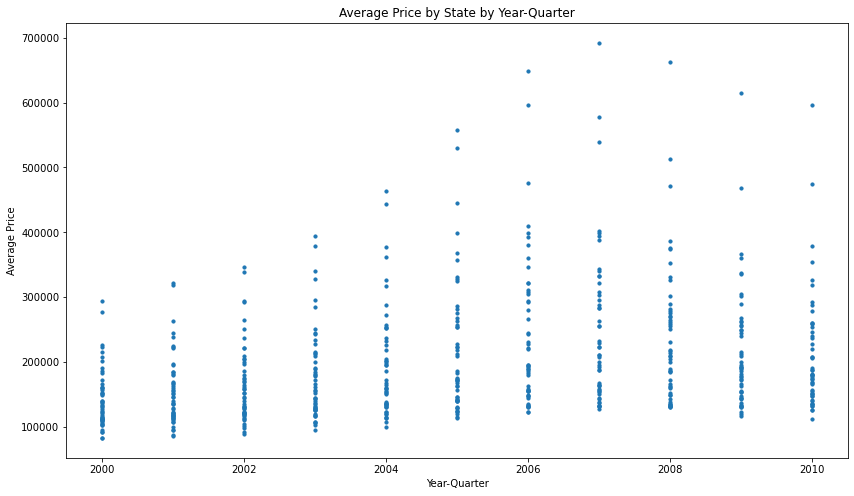

In [15]:
# Create some visualizations with state stats dataframe.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.scatter(df_state_stats['Year-Quarter'], df_state_stats['Average Price'], s=10)
plt.xlabel('Year-Quarter')
plt.ylabel('Average Price')
plt.title('Average Price by State by Year-Quarter')
plt.show()

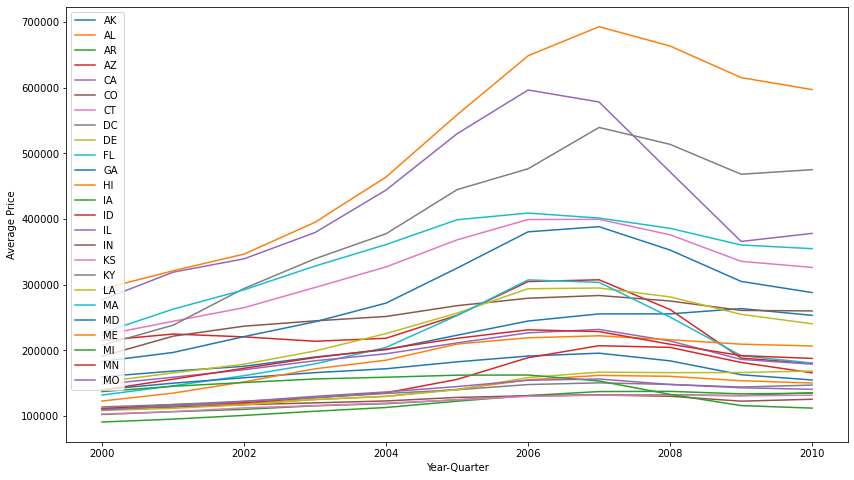

In [32]:
# Show a line graph by grouped state data.
# Group the data by state
grouped = df_state_stats.groupby('State')

# Create a line plot for each state
plt.figure(figsize=(14, 8))

# Show only half the data at a time (50 states at once is wild)
i = 0
for state, group in grouped:
    if i < 25:
        plt.plot(group['Year-Quarter'], group['Average Price'], label=state)
    else:
        break
    i += 1

# Add axis labels
plt.legend()
plt.xlabel('Year-Quarter')
plt.ylabel('Average Price')

# Show the plot
plt.show()

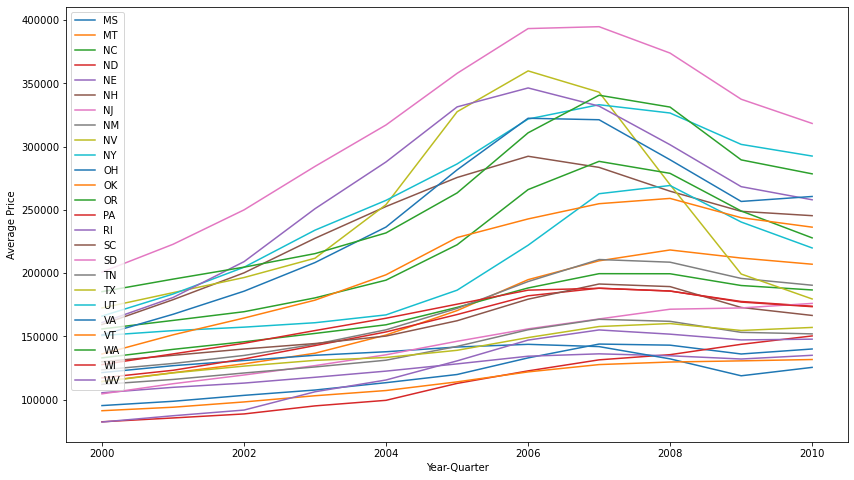

In [33]:
# Create a line plot for the second 25 states
plt.figure(figsize=(14, 8))

i = 0
for state, group in grouped:
    if i >= 25 and i < 50:
        plt.plot(group['Year-Quarter'], group['Average Price'], label=state)
    elif i >= 50:
        break
    i += 1

# Add axis labels
plt.legend()
plt.xlabel('Year-Quarter')
plt.ylabel('Average Price')

# Show the plot
plt.show()

In [40]:
# Calculate the percentage change for each state
df_change = df_state_stats.groupby('State').apply(lambda x: x['Average Price'].pct_change().iloc[-1]).reset_index(name='pct_change')

# Sort the states based on the percentage change
df_sorted = df_change.sort_values(by='pct_change', ascending=False)

# Get the top 5 states with the highest percentage change
top_states = df_sorted['State'].head(5).tolist()

print('Top 5 states with highest percentage change:')
print(top_states)

Top 5 states with highest percentage change:
['OH', 'ND', 'CA', 'IA', 'MS']


From the data presented above, we can see a drastic spike for quite a few states around the 2007-2008 timeline.  This was expected as the impact of the housing bubble crisis had a significant impact on homeowners and real-estate costs.  However, we can see some obvious outliers.  Ohio, North Dakota, California, Iowa, and Mississippi appear to have the highest percent change with Indiana, Nebraska, South Dakota, Kentucky, and Texas completing the top 10.  Since these locations have the highest fluctuations, it may make sense for them to have the biggest impact for future housing market crisises.  Let's dig into the other datasets to see what else can be determined.

## Methods

## Analysis

## Conclusion

## Assumptions

## Limitations

## Challenges

## Future Uses and Additional Applications

## Recommendations

## Implementation Plan

## Ethical Assessment

## Appendix

## 10 Questions From the Audience

## References

Federal Housing Finance Agency. (2022). House Price Index Datasets [Data set]. Retrieved from https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx

Parker, K., & Stepler, R. (2021, August 2). As national eviction ban expires, a look at who rents and who owns in the U.S. Pew Research Center. https://www.pewresearch.org/fact-tank/2021/08/02/as-national-eviction-ban-expires-a-look-at-who-rents-and-who-owns-in-the-u-s/

Yasser, H. (2020). Housing Prices Dataset. Kaggle. Retrieved February 14, 2023, from https://www.kaggle.com/datasets/yasserh/housing-prices-dataset
